<a href="https://colab.research.google.com/github/OLaprevote/experiment-utilities/blob/main/fit_binding_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting anisotropy curves. Read this before use.


## Data guideline

Anisotropy values are usually lower than one. If you have anisotropies higher than that, then they are most probably expressed in milli-anisotropy (although anisotropy has no unit).

I refer to "ligand" as the titration chemical. It can be protein, DNA or a small molecule: whatever you titrate with will be called the ligand. Whatever it binds to (that has a constant concentration and fluoresce) will be called the macromolecule.

Your first column should be the concentration of your ligand in nM. All of the other columns should be different cycles. Provide at least 3. Keep the anisotropy when there is no ligand (only the fluorescent probe): it's used to compute the anisotropy baseline.

## Fitting and statistics

`lmfit` is used to fit the data with a least-square regression.

A few things that you should look at after fitting:
- Does one of your parameter reach its minimum or maximum lower bound?
- Is the residual plot normally distributed (or looking similar to the residual plot made using fake data)?

`lmfit` results gives you a few statistical values to help understand your fit:
- The chi-square value indicates if the scatter you see around the curve is as predicted given the scatter/standard deviation of your data (assuming a gaussian distribution), or if it is too high. A high chi-square means a scatter higher than expected, hence indicates that the fit may be wrong. If you don't have a standard error on your data point then the chi-square is the residual sum of square (RSS) (For more infos see [this website](https://www.graphpad.com/support/faq/some-nonlinear-regression-programs-report-the-chi-square-of-a-fit-what-does-this-mean-why-doesnt-prism-report-the-chi-square-value/)
- Reduced chi-square: chi-square / n - m. With n the number of observations and m the number of fitted parameters. <1: model is overfitting. ~1: data scattering around the curve is within expectation of its error. >>1: poor model fit. [See Wikipedia](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic) (Note it doesn't mean much if there's no standard error on your data point)
- Akaike and Bayesian info criterion (AIC and BIC) show how well a model fits a curve compared to another model. They should only be used for comparison between models. They have no meaning otherwise, i.e the AIC or the BIC may be -3000 or 380000, if it's not used to compare with another model fitting the same data then it doesn't mean anything.
- The lower AIC or BIC, the better. Let's take two models, with AIC1 < AIC2 and ΔAIC = AIC2 - AIC1:
  - ΔAIC > 10: Strong difference between the two models. Model 2 is spewing garbage compared to model 1.
  - ΔAIC ~ 0-2: the two models are comparable, and model 2 seems just as good a model 1.
  - ΔAIC ~ 4-7: clear difference between model 1 (better) and model 2 (worst).¹

*1: Burnham, Kenneth P. and David R. Anderson. 2002. Model Selection and Multimodel Inference: A Practical Information-Theoretical Approach. p.70-71. (Book available in ubt library)*

In [88]:
#@title Install lmfit
!pip install lmfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [106]:
#@title Upload files { vertical-output: true }
#@markdown Click on the **play** ▶️ button on the left, then on **Choose files** bellow to upload all your files.
#@markdown 
#@markdown You can select multiple files to upload by clicking on them while pressing Ctrl.

# Define useful functions
import functools
import inspect
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
import pandas as pd
from scipy import constants
import seaborn as sns

try:
    from google.colab import files
    is_colab = True
except ImportError:
    is_colab = False
    #TODO
    raise Exception('This notebook is currently only supported on Google Colab.'
                    ' To port it to a local notebook one needs to replace google.colab'
                    " files upload by the ipython widget upload. Trivial, but I "
                    " didn't feel like doing then testing it.")


def deltaG_to_kd(deltaGs, temperature):
    """Convert free binding energies to dissociation constants

    Free binding energies in kcal/mol, temperature in Kelvin,
    Dissociation constants as a numpy.array in nM.
    Kd = exp(ΔG/(R*T))
    """
    kds = np.exp(-np.array(deltaGs)
        / (temperature * constants.gas_constant/(constants.calorie*1000))
    ) * 1e9 # nM
    return kds


def kd_to_deltaG(kds, temperature):
    """Convert dissociation constants to free binding energies
    
    Dissociation constants in nM, temperature in Kelvin,
    Free binding energies as a numpy.array in kcal/mol.
    ΔG = R*T*ln(Kd)
    """
    deltaGs = (-temperature * constants.gas_constant/(constants.calorie*1000)
        * np.log(np.array(kds) / 1e9)
    )
    return deltaGs

def kds_to_betas(kds):
    betas = [1] + [1/np.product(kds[:i]) for i in range(1, len(kds)+1)]
    return betas


def get_c_lig_tot(c_free_ligand, c_macromol_tot, betas):
    """Find concentration of total ligand
    
    Given the concentration of free ligands and macromolecules,
    and a list of overall association constants.
    """
    weighted_fractions = np.arange(len(betas)) * betas
    n_lb = Polynomial(weighted_fractions)(c_free_ligand) / Polynomial(betas)(c_free_ligand)
    c_lig_tot = (c_free_ligand + c_macromol_tot * n_lb)
    return c_lig_tot, n_lb
    

def get_signal_lig_tot(c_lig_tot, c_macromol_tot, betas, partial_anisos):
    """Compute fluorescence anisotropy given a ligand concentration"""

    # Find concentratration of free ligand
    # by solving [L]tot = [L] + [M]tot * n_LB
    # <=> - P*[L]tot + P*[L] + [M]tot * sum(i * beta_i * [L]) = 0
    # (roots are [L] corresponding to [L]tot.
    binding_polynomial = Polynomial(betas)
    binding_polynomial_L = Polynomial([0] + betas)  # One order up
    weighted_fractions = np.arange(len(betas)) * betas
    bound_ligand = c_macromol_tot * Polynomial(weighted_fractions)
    p = (bound_ligand
       + binding_polynomial_L
       - c_lig_tot * binding_polynomial
       )
    roots = p.roots()
    try:
        c_free_lig = np.real(roots[(roots >= 0) & (np.imag(roots) == 0)][0])
    except IndexError:
        #print(roots, '\n', p, '\n', c_lig_tot, '\n', betas)
        raise

    # Find anisotropy signal
    fractions = np.array([beta * c_free_lig**i / binding_polynomial(c_free_lig)
                          for i, beta in enumerate(betas)])
    aniso_signal = sum(partial_anisos * fractions)

    return aniso_signal, fractions


def make_aniso_function(num_bindings):
    """Make a function to compute anisotropy signal suited for fitting

    Dark python voodoo.
    Create a function with deltaG_i and aniso_i arguments
    See https://stackoverflow.com/a/60638430/13382030
    """
    param_names = (['c_lig_tot', 'c_macromol_tot', 'temperature']
        + [f'deltaG_{i}' for i in range(1, num_bindings+1)]
        + [f'aniso_{i}' for i in range(num_bindings+1)]
    )
    params = [inspect.Parameter(name, inspect.Parameter.POSITIONAL_OR_KEYWORD)
           for name in param_names]
    sig = inspect.Signature(params)

    def aniso_function(*args, **kwargs):
        # Get the arguments. Necessary to have a modular function.
        bound = sig.bind(*args, **kwargs) # compute the bound parameter list
        c_lig_tot = bound.arguments['c_lig_tot']
        c_macromol_tot = bound.arguments['c_macromol_tot']
        temperature = bound.arguments['temperature']
        partial_anisos = [v for k, v in bound.arguments.items() if k.startswith('aniso')]
        deltaGs = [v for k, v in bound.arguments.items() if k.startswith('deltaG')]

        # Compute overall association constants
        kds = deltaG_to_kd(deltaGs, temperature)
        betas = kds_to_betas(kds)
        array_aniso = lambda x: get_signal_lig_tot(x, c_macromol_tot, betas, partial_anisos)[0]
        aniso_signal = np.array(list(map(array_aniso, c_lig_tot)))
        return aniso_signal

    aniso_function.__signature__ = sig
    return aniso_function
    

def summarize_fit(result):
    perr = np.sqrt(np.diag(result.covar))
    partial_anisos = [v for k, v in result.best_values.items() if k.startswith('aniso')]
    deltaGs = [v for k, v in result.best_values.items() if k.startswith('deltaG')]
    nb = len(deltaGs) # Number of binding events
    # Sort all this out
    summary_dict = {
        'binding': list(range(1, nb+1)),
        'ΔG_{i,i-1}': deltaGs, # kcal/mol
        'stdev ΔG_{i,i-1}': perr[:nb] # kcal/mol
    }

    summary = pd.DataFrame(summary_dict)

    summary['Kd'] = deltaG_to_kd(summary['ΔG_{i,i-1}'], temperature) # nM
    summary['β'] = [1/np.product(summary['Kd'][:i+1]) for i in range(nb)] # in nM^-i
    summary['ΔG_i'] = [np.sum(summary['ΔG_{i,i-1}'][:i]) for i in range(1, nb+1)]
    summary['stderr ΔG_i'] = np.sqrt([np.sum(result.covar[:i,:i]) for i in range(1, nb+1)])
    summary['partial aniso'] = partial_anisos[1:]
    summary['stdev aniso'] = perr[nb+1:]

    no_binding = pd.DataFrame({'binding': [0], 'partial aniso': [partial_anisos[0]],
        'stdev aniso': [perr[nb]]})
    summary = pd.concat((no_binding, summary), sort=False, ignore_index=True)

    return summary

# Get files
if is_colab:
    uploaded = files.upload()
    !mkdir -p inp
    for fn in uploaded.keys():
        !mv "$fn" "inp/$fn"
    fpath_list = [f'inp/{fn}' for fn in uploaded.keys()]
else:
    fpath_list = [] # Put files you want here

if fpath_list == []:
    import glob
    fpath_list = glob.glob('inp/*.csv')
    fpath_list = [fpath for fpath in fpath_list if not '(' in fpath]
    print('No file inputed. These files will hence be used:\n -',
          '\n - '.join(fpath_list))

all_aniso_df = pd.DataFrame()
all_stat_aniso_df = pd.DataFrame()
aniso_df_list = []

for f in fpath_list:
    # Read file
    aniso_df = pd.read_csv(f)
    stat_aniso_df = pd.DataFrame(aniso_df.iloc[:,0])
    stat_aniso_df['avg aniso'] = aniso_df.iloc[:,1:].mean(axis=1)
    stat_aniso_df['stdev aniso'] = aniso_df.iloc[:,1:-1].std(axis=1)

    aniso_df = aniso_df.melt('[2TrpR] (nM)', var_name='Cycle',
                             value_name='Anisotropy')

    aniso_baseline = np.average(
        aniso_df['Anisotropy'][aniso_df['[2TrpR] (nM)'] == 0.0])
    stat_aniso_df['ground avg aniso'] = stat_aniso_df['avg aniso'] - aniso_baseline
    aniso_df['ground anisotropy'] = aniso_df['Anisotropy'] - aniso_baseline

    aniso_df['file'] = stat_aniso_df['file'] = f

    all_stat_aniso_df = pd.concat([all_stat_aniso_df, stat_aniso_df], axis=0)
    all_aniso_df = pd.concat([all_aniso_df, aniso_df], axis=0)
    aniso_df_list.append([aniso_df, stat_aniso_df])

# x and y given as array_like objects
import plotly.express as px
fig = px.scatter(all_aniso_df, x='[2TrpR] (nM)', y='ground anisotropy',
                 color='file', hover_data=['Cycle'], log_x=True)
fig.show()

Saving 2022-10-19_bsa-1_tween20-0p05_1h00.csv to 2022-10-19_bsa-1_tween20-0p05_1h00.csv
Saving 2022-10-19_bsa-1_tween20-0p05_2h25.csv to 2022-10-19_bsa-1_tween20-0p05_2h25.csv


In [107]:
#@title Fit (give initial guesses) { vertical-output: true }

# 3 binding events with Kds bounds = [1e6, 1e9], [1e-7, 1e-3], [1, 1e5]
from lmfit import Model, Parameters

# Parameters
#@markdown **Labels** for the proteins or conditions, each label separated by a comma:
labels = "1 BSA - 0.05 Tween20 - 1h00, 1 BSA - 0.05 Tween20 - 2h25" #@param {type:"string"}
label_list = labels.split(', ')

#@markdown **Total macromolecule concentration** in nM
c_macromol_tot = 0.5 #@param {type:"number"}

#@markdown **Temperature** in °C
temperature = 20 #@param {type:"number"}

# Convert from celsius to kelvin
temperature = constants.convert_temperature(temperature, old_scale='Celsius',
                                            new_scale='Kelvin')

#@markdown **List of initial guess for $K_{D}$** in nM. The number of binding event
#@markdown is infered from the number of $K_{D}$ provided.
#@markdown
#@markdown *Use only one list to use these guesses for all files (Ex 2 binding events: [1, 10] ).*
#@markdown
#@markdown *Use a list of list to use different guesses for each files (Ex for 2 files: [[1, 10], [10, 100]] ).*
kds0_list = [1e3, 1e-1, 900] #@param
if not hasattr(kds0_list[0], '__iter__'):
    kds0_list = [kds0_list] * len(label_list)

#@markdown **List of boundaries for $K_{D}$** in nM.
#@markdown
#@markdown Use only one list of list to use these guesses for all files (Ex: [[1e-1, 1e3], [1e0, 1e4]] ).
#@markdown
#@markdown Use a 3D-list to use different guesses for each files (Ex for 2 files: [[[1e-1, 1e3], [1e0, 1e4]], [[1e-1, 1e3], [1e0, 1e4]]] ).
bounds_kds_list = [[1e-1, 1e5], [1e-2, 1e5], [10, 1e5]] #@param
if not hasattr(bounds_kds_list[0][0], '__iter__'):
    bounds_kds_list = [bounds_kds_list] * len(label_list)

#@markdown **List of initial guess for partial signals**.
#@markdown
#@markdown Same logic as $K_D$. Note that for n binding events there are n+1 partial 
#@markdown signals (counting the ground one).
#@markdown
#@markdown Leaving out 1 partial signal will set $S_0$ to the average of the signal when there is no ligand.
#@markdown Leaving out 2 partial signals will also set $S_n$ to the highest signal value.
partial_anisos0_list = [8, 14] #@param
if not hasattr(partial_anisos0_list[0], '__iter__'):
    partial_anisos0_list = [partial_anisos0_list] * len(label_list)

#@markdown **List of boundaries for partial signals**.
#@markdown
#@markdown There are n+1 partial signals. Same logic as for boundaries of $K_D$.
#@markdown
#@markdown Only one number as the boundary sets them to [guess/number, guess*number].
#@markdown Two numbers as the boundary sets them to [guess+number0, guess+number1].
bounds_anisos_list = [[-1, 1], 1.5, 1.2, 1.5] #@param
if any(isinstance(k, (int, float)) for k in bounds_anisos_list):
    bounds_anisos_list = [bounds_anisos_list] * len(label_list)

# Prep summarizing dataframes and dict
all_aniso_df = pd.DataFrame()
all_stat_aniso_df = pd.DataFrame()
results = dict()

for (aniso_df, stat_aniso_df), label, kds0, bounds_kds, partial_anisos0, bounds_anisos in zip(
        aniso_df_list, label_list, kds0_list, bounds_kds_list,
        partial_anisos0_list, bounds_anisos_list):

    aniso_df['label'] = label
    stat_aniso_df['label'] = label

    all_stat_aniso_df = pd.concat([all_stat_aniso_df, stat_aniso_df], axis=0)
    all_aniso_df = pd.concat([all_aniso_df, aniso_df], axis=0)

    # Values to fit
    x = np.array(aniso_df.iloc[:,0])
    y = np.array(aniso_df['ground anisotropy'])
    stdev = np.array(stat_aniso_df['stdev aniso'])
    weights = [1 / dev if dev != 0 else 1 for dev in stdev]

    # Initial guess
    # -------------
    deltaG0 = list(kd_to_deltaG(kds0, temperature)) # kcal/mol
    aniso_baseline = np.average(y[x == 0])
    if len(partial_anisos0) + 1 == len(kds0):
        partial_anisos0 = [aniso_baseline] + partial_anisos0 + [max(y)]
    elif len(partial_anisos0) == len(kds0):
        partial_anisos0 = [aniso_baseline] + partial_anisos0
    elif len(partial_anisos0) - 1 != len(kds0):
        raise Exception("You did something weird with partial_anisos0_list. This won't work.")
    p0 = deltaG0 + partial_anisos0

    # Parameters boundaries
    # ---------------------
    bounds_kds = np.array(bounds_kds).T # nM
    bounds_deltaG = np.array([kd_to_deltaG(kds, temperature) for kds in bounds_kds][::-1])
    # bounds_deltaG = np.array([kd_to_deltaG(kds, temperature) for kds in bounds_kds])
    
    if isinstance(bounds_anisos[0], (float, int)):
        lowest_aniso = partial_anisos0[0] / bounds_anisos[0]
    else:
        lowest_aniso = partial_anisos0[0] + bounds_anisos[0][0]
    if isinstance(bounds_anisos[-1], (float, int)):
        highest_aniso = partial_anisos0[-1]*bounds_anisos[-1]
    else:
        highest_aniso = partial_anisos0[-1] + bounds_anisos[-1][1]
    
    bounds_anisos = [
        [max(lowest_aniso, aniso0/factor), min(highest_aniso, aniso0*factor)]
        if isinstance(factor, (int, float)) else aniso0+factor
        for aniso0, factor in zip(partial_anisos0, bounds_anisos)
    ]
    bounds_anisos = np.array(bounds_anisos).T
    bounds = np.concatenate([bounds_deltaG, bounds_anisos], axis=1)

    # For lmfit
    # ---------
    deltaG_params = {f'deltaG_{i+1}': deltaG for i, deltaG in enumerate(deltaG0)}
    aniso_params = {f'aniso_{i}': aniso for i, aniso in enumerate(partial_anisos0)}
    params_dict = dict(
        name=(['c_macromol_tot', 'temperature'] + list(deltaG_params.keys()) + list(aniso_params.keys())),
        value=([c_macromol_tot, temperature] + list(deltaG_params.values()) + list(aniso_params.values())),
        vary=[False, False] + [True for p in p0],
        min=[None, None] + list(bounds[0]),
        max=[None, None] + list(bounds[1])
    )
    params_df = pd.DataFrame(params_dict)
    params = Parameters()
    for idx, row in params_df.iterrows():
        params.add(**row)

    # Make model
    num_bindings = len(deltaG0)
    aniso_function = make_aniso_function(num_bindings)
    aniso_model = Model(aniso_function)

    # Fit
    results[label] = [x, None]
    result = results[label][1] = aniso_model.fit(y, params, c_lig_tot=x, method='least_squares')
    #display(result)

    # Compute & show Kd, beta and total ΔG
    # ------------------------------------
    print(f'Label: {label}\n'
        f'Chi-square: {result.chisqr:.3f}; Reduced chi-square: {result.redchi:.3f}; '
        f'Akaike info crit.: {result.aic:.3f}')
    summary = summarize_fit(result)
    display(summary)




Label: 1 BSA - 0.05 Tween20 - 1h00
Chi-square: 792.854; Reduced chi-square: 8.908; Akaike info crit.: 216.684


,binding,partial aniso,stdev aniso,"ΔG_{i,i-1}","stdev ΔG_{i,i-1}",Kd,β,ΔG_i,stderr ΔG_i
0,0,0.179289,0.839453,NaN,NaN,NaN,NaN,NaN,NaN
1,1,12.000000,10077.390352,6.777537,339.374180,8857.196859,0.000113,6.777537,339.374180
2,2,13.613674,1.250551,14.755052,339.135067,0.010000,0.011290,21.532590,0.870191
3,3,28.892946,1.219783,7.194298,0.234886,4331.099264,0.000003,28.726888,0.814957


Label: 1 BSA - 0.05 Tween20 - 2h25
Chi-square: 341.990; Reduced chi-square: 3.843; Akaike info crit.: 135.962


,binding,partial aniso,stdev aniso,"ΔG_{i,i-1}","stdev ΔG_{i,i-1}",Kd,β,ΔG_i,stderr ΔG_i
0,0,0.400237,0.552548,NaN,NaN,NaN,NaN,NaN,NaN
1,1,12.000000,27.339844,10.083929,0.985530,30.363869,0.032934,10.083929,0.985530
2,2,13.048169,0.963644,11.357364,0.972759,3.411948,0.009653,21.441293,0.852782
3,3,28.987089,0.740137,7.328759,0.152556,3438.400157,0.000003,28.770052,0.801766


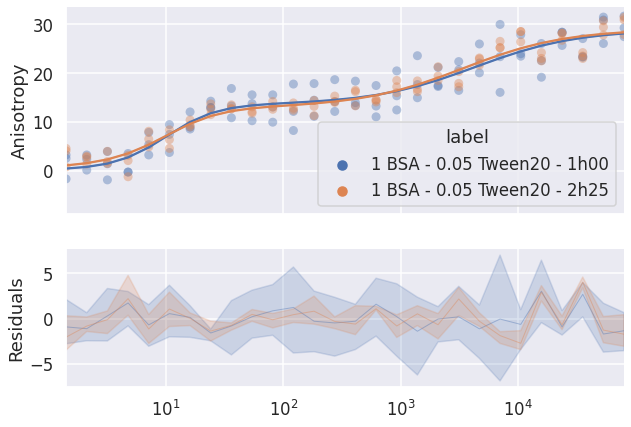

In [108]:
#@title Plot all fits { vertical-output: true }
# Plot
context = "talk" #@param ["talk", "paper", "notebook", "poster"]
sns.set(context=context)
fig1, axes = plt.subplots(2, figsize=(10, 7), sharex=True,
            gridspec_kw={'height_ratios': [3, 2]}) 

colors = {label: color for label, color in
          zip(label_list, sns.color_palette(n_colors=len(label_list)))}

# Plot data and fit
sns.scatterplot(x='[2TrpR] (nM)', y='ground anisotropy', data=all_aniso_df,
                hue='label', ci='sd', alpha=0.4, linewidth=0, ax=axes[0])

for label, (x, result) in results.items():
    #@markdown Confidence interval of uncertainty. 0 to not show any.
    fit_uncertainty = 0 #@param {type:"number"}
    if fit_uncertainty:
        dely = result.eval_uncertainty(sigma=1)
        axes[0].fill_between(x=x, y2=result.best_fit-dely, y1=result.best_fit+dely,
                            where=x>1e-2, facecolor=colors[label], alpha=0.05)

    sns.lineplot(x=x, y=result.best_fit, legend=False, ax=axes[0])


    # Plot residual
    sns.lineplot(x=x, y=result.residual,
                 alpha=0.4, linewidth=1, ax=axes[1])
    #sns.scatterplot(x=x, y=result.residual,
    #                alpha=0.4, linewidth=0, ax=axes[1], legend=False)

# Make the figure pretty
for ax in axes:
      ax.set_xlim(min(x[x > 1e-2]), max(x))
      ax.set_xscale('log')

axes[0].set_ylabel('Anisotropy')
axes[1].set_ylabel('Residuals')

#fig1.set_facecolor('white')
sns.despine()

In [109]:
#@title Download tables (csv or excel)
#@markdown Register fit infos on different sheets for excel, or multiple files for csv.
format = 'xlsx' #@param ['csv', 'xlsx']
!mkdir -p summary
all_stats = pd.DataFrame()

if format == 'xlsx':
    fn = f'summary/{fpath_list[0][4:-4]}_etc_fit-summary.{format}'

for (x, result), (aniso_df, stat_aniso_df) in zip(results.values(), aniso_df_list):
    summary = summarize_fit(result)
    stats = dict(chisquare = [result.chisqr],
                    redchisqr = [result.redchi],
                    aic = [result.aic])
    stats = pd.DataFrame(stats)
    name = aniso_df['file'][0][4:-4]
    if format == 'csv':
        fn = f'summary/{name}_fit-summary.{format}'
        print(fn)
        summary.to_csv(fn, index=False)
        stats.to_csv(fn, index=False, mode='a')
    elif format == 'xlsx':
        try:
            with pd.ExcelWriter(fn, mode='a', if_sheet_exists='replace') as writer:
                summary.to_excel(writer, sheet_name=name, index=False)
        except FileNotFoundError:
            with pd.ExcelWriter(fn, mode='w') as writer:
                summary.to_excel(writer, sheet_name=name, index=False)
        stats['fit'] = name
        all_stats = pd.concat([all_stats, stats], axis=0)

    from lmfit.model import save_modelresult
    save_modelresult(result, f'summary/{name}_model.sav')

if format == 'xlsx':
    with pd.ExcelWriter(fn, mode='a', if_sheet_exists='replace') as writer:
        all_stats.to_excel(writer, sheet_name='stats', index=False)

zip_fn = fpath_list[0][:-4] + '_etc_fit-summary.zip'
!zip -r $zip_fn 'summary'
files.download(zip_fn)

/usr/local/lib/python3.7/dist-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



  adding: summary/ (stored 0%)
  adding: summary/2022-10-19_bsa-0p1_tween20-0_0h35_model.sav (deflated 65%)
  adding: summary/2022-10-19_bsa-0_tween20-0p01_0h45_etc_fit-summary.xlsx (deflated 10%)
  adding: summary/2022-10-19_bsa-1_tween20-0p05_2h25_model.sav (deflated 65%)
  adding: summary/2022-10-19_bsa-1_tween20-0p01_1h00_etc_fit-summary.xlsx (deflated 11%)
  adding: summary/2022-10-19_bsa-0p1_tween20-0p01_0h35_etc_fit-summary.xlsx (deflated 10%)
  adding: summary/2022-10-19_bsa-0p1_tween20-0_0h35_etc_fit-summary.xlsx (deflated 11%)
  adding: summary/2022-10-19_bsa-0_tween20-0p01_2h25_model.sav (deflated 65%)
  adding: summary/2022-10-19_bsa-1_tween20-0_0h45_etc_fit-summary.xlsx (deflated 11%)
  adding: summary/2022-10-19_bsa-1_tween20-0_2h25_model.sav (deflated 65%)
  adding: summary/2022-10-19_bsa-0_tween20-0p05_0h45_etc_fit-summary.xlsx (deflated 11%)
  adding: summary/2022-10-19_bsa-0_tween20-0_0h45_model.sav (deflated 64%)
  adding: summary/2022-10-19_bsa-0p1_tween20-0p05_1h00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [110]:
#@title Download all fits graph
!mkdir -p graph

format = 'pdf' #@param ['emf', 'eps', 'pdf', 'png', 'ps', 'raw', 'rgba', 'svg', 'svgz']
fn = f'graph/{fpath_list[0][4:-4]}_all-fits.{format}'
fig1.savefig(fn)
files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

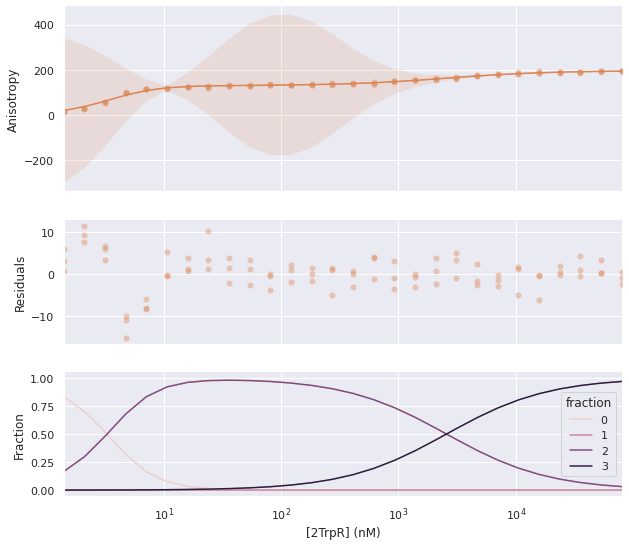

In [33]:
#@title Plot only one label { vertical-output: true }
# Plot
context = "notebook" #@param ["talk", "paper", "notebook", "poster"]
label = "0 BSA - 0 Tween20 - 2h10" #@param {type:"string"}
color = colors[label]
sns.set(context=context)
x, result = results[label]
aniso_df = all_aniso_df[all_aniso_df['label'] == label]

fig2, axes = plt.subplots(3, figsize=(10, 9), sharex=True,
            gridspec_kw={'height_ratios': [3, 2, 2]}) 

# Plot data and fit
#@markdown Confidence interval of uncertainty. 0 to not show any.
fit_uncertainty = 0.95 #@param {type:"number"}
if fit_uncertainty:
    dely = result.eval_uncertainty(sigma=fit_uncertainty)
    axes[0].fill_between(x=x, y2=result.best_fit-dely, y1=result.best_fit+dely,
                         where=x>1e-2, facecolor=color, alpha=0.05)

sns.lineplot(x=x, y=result.best_fit, legend=False, color=color, ax=axes[0])
sns.scatterplot(x='[2TrpR] (nM)', y='ground anisotropy', data=aniso_df,
                color=color, ci='sd', alpha=0.4, linewidth=0, ax=axes[0])

# Plot residual
sns.scatterplot(x=x, y=result.residual, color=color,
                alpha=0.4, linewidth=0, ax=axes[1], legend=False)

# Plot fractions
# Compute fractions
summary = summarize_fit(result)
pbeta_nM = [1] + list(summary['β'].dropna())
ppartial_anisos = list(summary['partial aniso'])
fractions_fit = [get_signal_lig_tot(conc_l, c_macromol_tot, pbeta_nM, ppartial_anisos)[1] for conc_l in x]

fractions_df = pd.DataFrame(fractions_fit)
fractions_df['[2TrpR] (nM)'] = x
fractions_dfm = fractions_df.melt('[2TrpR] (nM)', var_name='fraction', value_name='f')

sns.lineplot(x='[2TrpR] (nM)', y='f', data=fractions_dfm, hue='fraction', ax=axes[2])

# Make the figure pretty
for ax in axes:
      ax.set_xlim(min(x[x > 1e-2]), max(x))
      ax.set_xscale('log')

axes[0].set_ylabel('Anisotropy')
axes[1].set_ylabel('Residuals')
axes[2].set_ylabel('Fraction')

#fig2.set_facecolor('white')
sns.despine()

In [ ]:
#@title Download one label graph
!mkdir -p graph
format = 'svg' #@param ['emf', 'eps', 'pdf', 'png', 'ps', 'raw', 'rgba', 'svg', 'svgz']
fn = f'graph/{label}_fit.{format}'
fig2.savefig(fn)
files.download(fn)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>